In [1]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision import transforms
import argparse
import datetime
import os
from tensorboardX import SummaryWriter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics

class MRNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.pretrained_model = models.alexnet(pretrained=True)
        self.pooling_layer = nn.AdaptiveAvgPool2d(1)
        self.classifer = nn.Linear(256, 1)

    def forward(self, x):
        x = torch.squeeze(x, dim=0) 
        features = self.pretrained_model.features(x)
        pooled_features = self.pooling_layer(features)
        pooled_features = pooled_features.view(pooled_features.size(0), -1)
        flattened_features = torch.max(pooled_features, 0, keepdim=True)[0]
        output = self.classifer(flattened_features)
        return output

In [2]:
class MRDataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, task, plane, train=True, transform=None, weights=None):
        super().__init__()
        self.task = task
        self.plane = plane
        self.root_dir = root_dir
        self.train = train
        if self.train:
            self.folder_path = self.root_dir + 'train/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'train-{0}.csv'.format(task), header=None, names=['id', 'label'])
        else:
            transform = None
            self.folder_path = self.root_dir + 'valid/{0}/'.format(plane)
            self.records = pd.read_csv(
                self.root_dir + 'valid-{0}.csv'.format(task), header=None, names=['id', 'label'])

        self.records['id'] = self.records['id'].map(
            lambda i: '0' * (4 - len(str(i))) + str(i))
        self.paths = [self.folder_path + filename +
                      '.npy' for filename in self.records['id'].tolist()]
        self.labels = self.records['label'].tolist()

        self.transform = transform
        if weights is None:
            pos = np.sum(self.labels)
            neg = len(self.labels) - pos
            self.weights = [1, neg / pos]
        else:
            self.weights = weights

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        array = np.load(self.paths[index])
        label = self.labels[index]
        label = torch.FloatTensor([label])
        
        if self.transform:
            array = self.transform(array)
        else:
            array = np.stack((array,)*3, axis=1)
            array = torch.FloatTensor(array)

        if label.item() == 1:
            weight = np.array([self.weights[1]])
            weight = torch.FloatTensor(weight)
        else:
            weight = np.array([self.weights[0]])
            weight = torch.FloatTensor(weight)
        return array, label, weight

In [3]:
train_dataset = MRDataset('D:/MRNet-v1.0/MRNet-v1.0/', "acl", "sagittal",  train=True)
validation_dataset = MRDataset('D:/MRNet-v1.0/MRNet-v1.0/', "acl", "sagittal", train=False)

In [4]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=0, drop_last=False)

validation_loader = torch.utils.data.DataLoader(
    validation_dataset, batch_size=1, shuffle=-True, num_workers=0, drop_last=False)

In [5]:
mrnet = MRNet()
mrnet = mrnet.cuda()

optimizer = torch.optim.Adam(mrnet.parameters(), lr=1e-5, weight_decay=0.1)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3, factor=.3, threshold=1e-4, verbose=True)
best_val_loss = float('inf')
best_val_auc = float(0)
num_epochs = 50
patience = 2

In [6]:

def train_model(model, train_loader, epoch, num_epochs, optimizer):
    print("Epoch:",epoch+1)
    _ = model.train()
    if torch.cuda.is_available():
        model.cuda()
    y_preds = []
    y_trues = []
    losses = []

    for i, (image, label, weight) in enumerate(train_loader):
        optimizer.zero_grad()

        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        prediction = model.forward(image.float())
        
        loss = torch.binary_cross_entropy_with_logits(
            prediction[0], label[0], weight=weight[0])

        loss.backward()
        optimizer.step()
        
        y_pred = torch.sigmoid(prediction).item()
        y_true = int(label.item())

        y_preds.append(y_pred)
        y_trues.append(y_true)

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5

        loss_value = loss.item()
        losses.append(loss_value)
        
       
    
    train_loss_epoch = np.round(np.mean(losses), 4)
    train_auc_epoch = np.round(auc, 4)
    return train_loss_epoch, train_auc_epoch

In [7]:
def evaluate_model(model, val_loader, epoch, num_epochs):
    _ = model.eval()

    if torch.cuda.is_available():
        model.cuda()

    y_trues = []
    y_preds = []
    losses = []

    for i, (image, label, weight) in enumerate(val_loader):

        if torch.cuda.is_available():
            image = image.cuda()
            label = label.cuda()
            weight = weight.cuda()

        label = label[0]
        weight = weight[0]

        prediction = model.forward(image.float())

        prediction=torch.reshape(prediction,(1,))

        loss = torch.nn.BCEWithLogitsLoss(weight=weight)(prediction, label)

        loss_value = loss.item()
        losses.append(loss_value)

        probas = torch.sigmoid(prediction)

        y_trues.append(int(label[0]))
        y_preds.append(probas[0].item())

        try:
            auc = metrics.roc_auc_score(y_trues, y_preds)
        except:
            auc = 0.5
        
    val_loss_epoch = np.round(np.mean(losses), 4)
    val_auc_epoch = np.round(auc, 4)
    return val_loss_epoch, val_auc_epoch


In [8]:
train_loss_dict={}
train_auc_dict={}
val_loss_dict={}
val_auc_dict={}

In [9]:
for epoch in range(num_epochs):
    train_loss, train_auc = train_model(
        mrnet, train_loader, epoch, num_epochs, optimizer)
    val_loss, val_auc = evaluate_model(
        mrnet, validation_loader, epoch, num_epochs)
    
    train_auc_dict[epoch+1]=train_auc
    train_loss_dict[epoch+1]=train_loss
    val_loss_dict[epoch+1]=val_loss
    val_auc_dict[epoch+1]=val_auc
    
    print("train loss : {0} | train auc {1} | val loss {2} | val auc {3}".format(
        train_loss, train_auc, val_loss, val_auc))


    if (1) == 1:
        scheduler.step(val_loss)

    print('-' * 30)



Epoch: 1
train loss : 2.2363 | train auc 0.5548 | val loss 0.7785 | val auc 0.6874
------------------------------


D:\Anaconda3\envs\pytorch\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type MRNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


Epoch: 2
train loss : 0.8651 | train auc 0.8199 | val loss 0.7487 | val auc 0.7329
------------------------------
Epoch: 3
train loss : 0.597 | train auc 0.917 | val loss 0.6823 | val auc 0.7786
------------------------------
Epoch: 4
train loss : 0.3845 | train auc 0.9727 | val loss 0.6645 | val auc 0.8067
------------------------------
Epoch: 5
train loss : 0.2456 | train auc 0.993 | val loss 0.916 | val auc 0.7971
------------------------------
Epoch: 6
train loss : 0.1687 | train auc 0.998 | val loss 0.7838 | val auc 0.8114
------------------------------
Epoch: 7
train loss : 0.175 | train auc 0.9956 | val loss 0.92 | val auc 0.8541
------------------------------
Epoch: 8
train loss : 0.1116 | train auc 0.9996 | val loss 0.7663 | val auc 0.828
Epoch     7: reducing learning rate of group 0 to 3.0000e-06.
------------------------------
Epoch: 9
train loss : 0.0469 | train auc 1.0 | val loss 0.9118 | val auc 0.8499
------------------------------
Epoch: 10
train loss : 0.0371 | train 

In [43]:
def extract_predictions(task, plane, train=True):
    assert task in ['acl', 'meniscus', 'abnormal']
    assert plane in ['axial', 'coronal', 'sagittal']
    


    mrnet = torch.load("D:/Untitled Folder 1/model_acl_sagittal_val_auc_0.8067_val_loss0.6645_train_auc_0.9727_train_loss0.3845_epoch_4.pth")
    _ = mrnet.eval()
    
    train_dataset = MRDataset('D:/MRNet-v1.0/MRNet-v1.0/', "acl", "sagittal",  train=True)

    
    train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=1, shuffle=True, num_workers=0, drop_last=False)
    predictions = []
    labels = []
    with torch.no_grad():
        for image, label, _ in tqdm_notebook(train_loader):
            logit = mrnet(image.cuda())
            prediction = torch.sigmoid(logit)
            predictions.append(prediction.item())
            labels.append(label.item())

    return predictions, labels

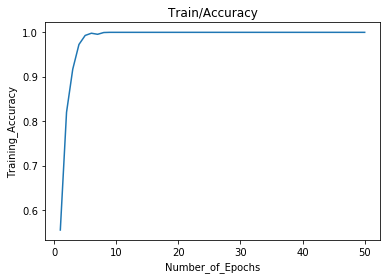

In [39]:
import matplotlib.pylab as plt

train_auc_lists = sorted(train_auc_dict.items()) # sorted by key, return a list of tuples

x, y = zip(*train_auc_lists) # unpack a list of pairs into two tuples
plt.xlabel("Number_of_Epochs")
plt.ylabel("Training_Accuracy")
plt.title("Train/Accuracy")
plt.plot(x, y)
plt.savefig("D:/Untitled Folder 1/Training_Accuracy.png")

plt.show()


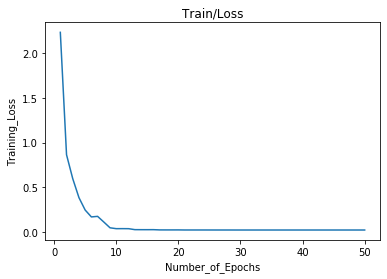

In [40]:
import matplotlib.pylab as plt

train_loss_lists = sorted(train_loss_dict.items()) # sorted by key, return a list of tuples

x, y = zip(*train_loss_lists) # unpack a list of pairs into two tuples
plt.xlabel("Number_of_Epochs")
plt.ylabel("Training_Loss")
plt.title("Train/Loss")
plt.plot(x, y)
plt.savefig("D:/Untitled Folder 1/Training_Loss.png")

plt.show()


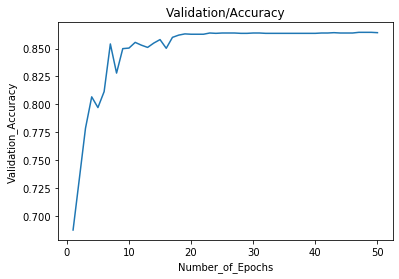

In [41]:
import matplotlib.pylab as plt

val_auc_lists = sorted(val_auc_dict.items()) # sorted by key, return a list of tuples

x, y = zip(*val_auc_lists) # unpack a list of pairs into two tuples
plt.xlabel("Number_of_Epochs")
plt.ylabel("Validation_Accuracy")
plt.title("Validation/Accuracy")

plt.plot(x, y)
plt.savefig("D:/Untitled Folder 1/Validation_Accuracy.png")
plt.show()


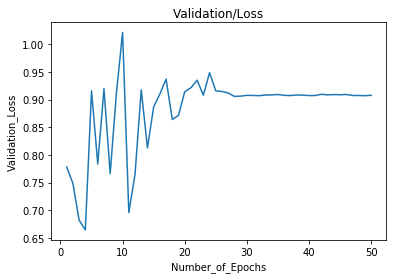

In [42]:
import matplotlib.pylab as plt

val_loss_lists = sorted(val_loss_dict.items()) # sorted by key, return a list of tuples

x, y = zip(*val_loss_lists) # unpack a list of pairs into two tuples
plt.xlabel("Number_of_Epochs")
plt.ylabel("Validation_Loss")
plt.title("Validation/Loss")
plt.plot(x, y)
plt.savefig("D:/Untitled Folder 1/Validation_Loss.png")
plt.show()
